# **Importing Modules and Dependencies**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm, trange
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

from PIL import Image
from torch.autograd import Variable

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# **Data**

In [ ]:

### to prepare dataset according to the input taken by torchvision


# Set the paths for the source and destination folders
source_folder = "/content/drive/MyDrive/smart_data_solutions/ML/data/images"
train_folder = "/content/drive/MyDrive/smart_data_solutions/ML/data/train"
test_folder = "/content/drive/MyDrive/smart_data_solutions/ML/data/test"

# Set the percentage for train and test split
train_percentage = 0.8
test_percentage = 0.2

# Create the train and test folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Get the list of subfolders (class folders) in the source folder
class_folders = os.listdir(source_folder)

# Iterate over each class folder
for class_folder in class_folders:
    # Create the destination folders for train and test
    train_class_folder = os.path.join(train_folder, class_folder)
    test_class_folder = os.path.join(test_folder, class_folder)
    os.makedirs(train_class_folder, exist_ok=True)
    os.makedirs(test_class_folder, exist_ok=True)

    # Get the list of images in the class folder
    # images = os.listdir(os.path.join(source_folder, class_folder))
    # print(source_folder)
    # print(class_folder)
    # print(type(class_folder))
    # print(images)
    # print(len(images))
    
    images_path=os.path.join(source_folder,class_folder)
    print(images_path)

    images_names=os.listdir(images_path)
    print(images_names)
    print(len(images_names))


    # Shuffle the images_names
    random.shuffle(images_names)

    # Calculate the split index based on the train and test percentages
    split_index = int(len(images_names) * train_percentage)

    # Split the images into train and test
    train_images = images_names[:split_index]
    test_images = images_names[split_index:]

    # Move the train images to the train class folder
    for train_image in train_images:
        source_path = os.path.join(source_folder, class_folder, train_image)
        destination_path = os.path.join(train_class_folder, train_image)
        shutil.copy(source_path, destination_path)

    # Move the test images to the test class folder
    for test_image in test_images:
        source_path = os.path.join(source_folder, class_folder, test_image)
        destination_path = os.path.join(test_class_folder, test_image)
        shutil.copy(source_path, destination_path)


In [ ]:
root="/content/drive/MyDrive/smart_data_solutions/ML/data"

#load train data and transform to tensor and normalize pixel values from 0-255 to 0-1
train_data = datasets.ImageFolder(root=f'{root}/train',
                                  transform=transforms.ToTensor()) #0-255 to 0-1

In [ ]:
#load test data and transform to tensor and normalize pixel values from 0-255 to 0-1
test_data = datasets.ImageFolder(root=f'{root}/test',
                                  transform=transforms.ToTensor()) #0-255 to 0-1

In [ ]:
#show img and label
count=0
for img, label in train_data:
  count=count+1
  print(f'{img}   /   {label}')
  if count>3:
    break

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])   /   0
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 

In [ ]:
#to print the classes and number of images in each class in train and test sets

root_path="/content/drive/MyDrive/smart_data_solutions/ML/data"

print('train')
for folder in train_data.classes:
  print(f'{folder} - {len(os.listdir(os.path.join(f"{root_path}/train",folder)))}')
print('\n')

print('test')
for folder in test_data.classes:
  print(f'{folder} - {len(os.listdir(os.path.join(f"{root_path}/test",folder)))}')
print('\n')

train
0 - 400
2 - 404
4 - 400
6 - 400
9 - 400


test
0 - 100
2 - 102
4 - 100
6 - 100
9 - 100




In [ ]:
#function to renormalize the images so that their colors look right for ploting the images

def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [ ]:
def plot_images(images, labels, classes, normalize=True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

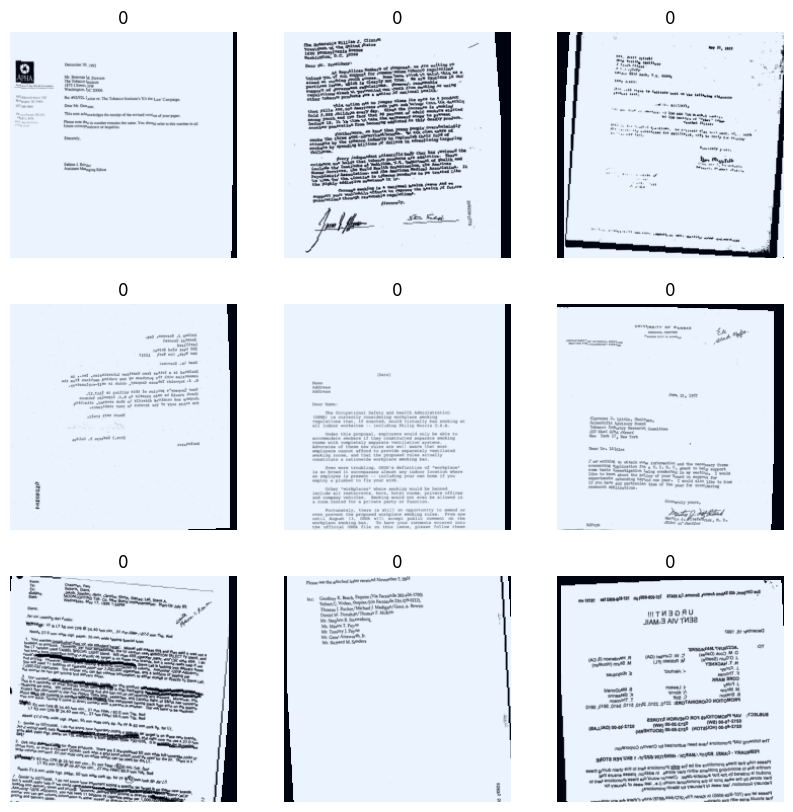

In [ ]:
#for ploting '0' category images

N_IMAGES = 10

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

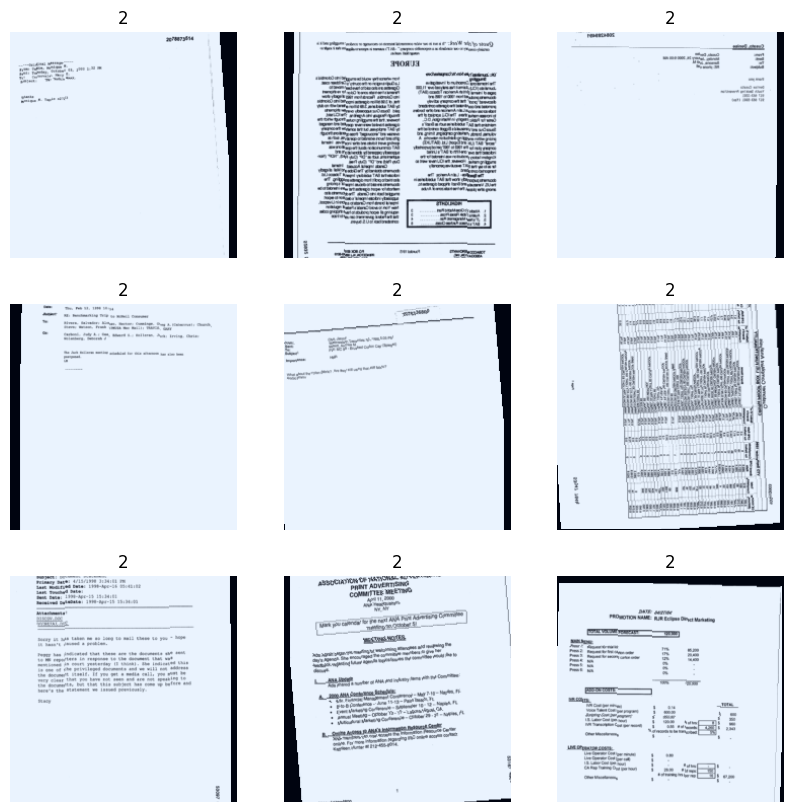

In [ ]:
#for ploting '2' category images

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(400,400+N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#define the transformers to transform data using pretrained size, means and standard deviations

pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [ ]:
#apply the transformations to the data

train_data=datasets.ImageFolder(root=f'{root_path}/train',
                                  transform=train_transforms)

test_data = datasets.ImageFolder(root=f'{root_path}/test',
                                  transform=test_transforms)

In [ ]:
print(len(train_data))
print(len(test_data))

2004
502


In [ ]:
#create the iterators with the batch size

train_loader=data.DataLoader(train_data,
                             batch_size=32,
                             shuffle=True)

test_loader=data.DataLoader(test_data,
                             batch_size=16,
                             shuffle=True)

In [ ]:
print(len(train_loader))
print(len(test_loader))

63
32


In [ ]:
classes=train_data.classes
print(classes)
num_classes=len(classes)
print(num_classes)

['0', '2', '4', '6', '9']
5


# **Model**

In [ ]:
#define the model

class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [ ]:
#namedtuple to store he block class, the number of blocks in each layer, and the number of channels in each layer

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [ ]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [ ]:
#confiurations for resnet 50
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

# **Pretrained Model**

In [ ]:
#load the pretrained resnet50 model
pretrained_model = models.resnet50(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 239MB/s]


In [ ]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)

fc = nn.Linear(IN_FEATURES, 5)  #make output features as 5 as we have 5 classes (unlike 1000 classes ImageNet dataset in which resnet was trained)

In [ ]:
#replace the pre-trained model's linear layer with our own, randomly initialized linear layer.

pretrained_model.fc = fc

In [ ]:
#We then initialize our ResNet50 model from the configuration
model = ResNet(resnet50_config, OUTPUT_DIM)

In [ ]:
#check to ensure our ResNet model matches those used by torchvision.

model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [ ]:
#count the model parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,518,277 trainable parameters


In [ ]:
#maximum learning rate is used for final layer whilst the remaining layers have a lower learning rate, gradually decreasing towards the input.

LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': LR / 10},
          {'params': model.bn1.parameters(), 'lr': LR / 10},
          {'params': model.layer1.parameters(), 'lr': LR / 8},
          {'params': model.layer2.parameters(), 'lr': LR / 6},
          {'params': model.layer3.parameters(), 'lr': LR / 4},
          {'params': model.layer4.parameters(), 'lr': LR / 2},
          {'params': model.fc.parameters()}
         ]

#define optimizer
optimizer = optim.Adam(params, lr =LR)

#define loss function
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
#function to calculate accuracy
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
from tqdm import tqdm
#training function

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    # count=0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        # count=count+1

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

        # if count==1:
        #   break

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
#evaluating function

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    # count=0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            # count=count+1

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            # if count==1:
            #   break

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# function which tells us how long an epoch has taken.
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
#train the model
num_epochs=10
save_model_path=os.path.join('/content/drive/MyDrive/smart_data_solutions/ML/models/model_resnet1.pt')

best_valid_loss = float('inf')

total_train_loss=[]
total_val_loss=[]

total_train_accuracy=[]
total_val_accuracy=[]

for epoch in trange(num_epochs,desc='Epochs'):
    
    start_time=time.monotonic()

    train_loss,train_accuracy=train(model,train_loader, optimizer,criterion,device)
    total_train_loss.append(train_loss)
    total_train_accuracy.append(train_accuracy)
    
    evaluate_loss,val_accuracy=evaluate(model,test_loader,criterion,device)
    total_val_loss.append(evaluate_loss)
    total_val_accuracy.append(val_accuracy)

    #only save if the validation loss decreases
    if evaluate_loss<best_valid_loss:
        best_valid_loss=evaluate_loss
        torch.save(model.state_dict(),save_model_path)

    end_time=time.monotonic()

    epoch_mins,epoch_sec=epoch_time(start_time,end_time)

    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_sec}s')
    print(f'\tTrain Loss: {train_loss}   |    Train accuracy: {train_accuracy}')
    print(f'\t Val. Loss: {evaluate_loss}   |   Val. accuacy: {val_accuracy}')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]


Training: 100%|██████████| 63/63 [14:21<00:00, 12.07s/it]
                                                         
Evaluating: 100%|██████████| 32/32 [03:32<00:00,  5.70s/it]
                                                           

Epoch: 01 | Time: 17m 54s
	Train Loss: 0.7829611840702239   |    Train accuracy: 0.7472222220330011
	 Val. Loss: 0.5429606437683105   |   Val. accuacy: 0.8346354179084301



Training: 100%|██████████| 63/63 [00:44<00:00,  1.66it/s]
                                                         
Evaluating: 100%|██████████| 32/32 [00:07<00:00,  5.02it/s]
                                                           

Epoch: 02 | Time: 0m 52s
	Train Loss: 0.5562669660836931   |    Train accuracy: 0.8220238099022518
	 Val. Loss: 0.5163103588856757   |   Val. accuacy: 0.8424479179084301



Training: 100%|██████████| 63/63 [00:44<00:00,  1.64it/s]
                                                         
Evaluating: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s]
                                                           

Epoch: 03 | Time: 0m 53s
	Train Loss: 0.4719707171122233   |    Train accuracy: 0.8426587307263934
	 Val. Loss: 0.5013694467488676   |   Val. accuacy: 0.84375



Training: 100%|██████████| 63/63 [00:44<00:00,  1.62it/s]
                                                         
Evaluating: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]
                                                           

Epoch: 04 | Time: 0m 52s
	Train Loss: 0.42116128996251123   |    Train accuracy: 0.8624007938400148
	 Val. Loss: 0.4650473608635366   |   Val. accuacy: 0.8619791679084301



Training: 100%|██████████| 63/63 [00:44<00:00,  1.59it/s]
                                                         
Evaluating: 100%|██████████| 32/32 [00:07<00:00,  5.09it/s]
                                                           

Epoch: 05 | Time: 0m 52s
	Train Loss: 0.3927359618837871   |    Train accuracy: 0.8748015874908084
	 Val. Loss: 0.3730494172486942   |   Val. accuacy: 0.865234375



Training: 100%|██████████| 63/63 [00:45<00:00,  1.51it/s]
                                                         
Evaluating: 100%|██████████| 32/32 [00:07<00:00,  5.10it/s]
                                                           

Epoch: 06 | Time: 0m 52s
	Train Loss: 0.37149865546869854   |    Train accuracy: 0.8870039686324105
	 Val. Loss: 0.41112606202659663   |   Val. accuacy: 0.865234375



Training: 100%|██████████| 63/63 [00:44<00:00,  1.48it/s]
                                                         
Evaluating: 100%|██████████| 32/32 [00:07<00:00,  4.89it/s]
                                                           

Epoch: 07 | Time: 0m 52s
	Train Loss: 0.3391092749578612   |    Train accuracy: 0.8904761908546327
	 Val. Loss: 0.6583259063772857   |   Val. accuacy: 0.818359375



Training: 100%|██████████| 63/63 [00:45<00:00,  1.59it/s]
                                                         
Evaluating: 100%|██████████| 32/32 [00:08<00:00,  5.03it/s]
                                                           

Epoch: 08 | Time: 0m 53s
	Train Loss: 0.32032546602071277   |    Train accuracy: 0.8947420640597268
	 Val. Loss: 0.5377581531647593   |   Val. accuacy: 0.8444010429084301



Training: 100%|██████████| 63/63 [00:44<00:00,  1.64it/s]
                                                         
Evaluating: 100%|██████████| 32/32 [00:08<00:00,  5.05it/s]
                                                           

Epoch: 09 | Time: 0m 52s
	Train Loss: 0.3078526732703996   |    Train accuracy: 0.9034722220330011
	 Val. Loss: 0.4522337975213304   |   Val. accuacy: 0.8795572929084301



Training: 100%|██████████| 63/63 [00:44<00:00,  1.63it/s]
                                                         
Evaluating: 100%|██████████| 32/32 [00:08<00:00,  4.60it/s]
                                                           

Epoch: 10 | Time: 0m 52s
	Train Loss: 0.26483394903323004   |    Train accuracy: 0.9188492061599852
	 Val. Loss: 0.462448864011094   |   Val. accuacy: 0.876953125


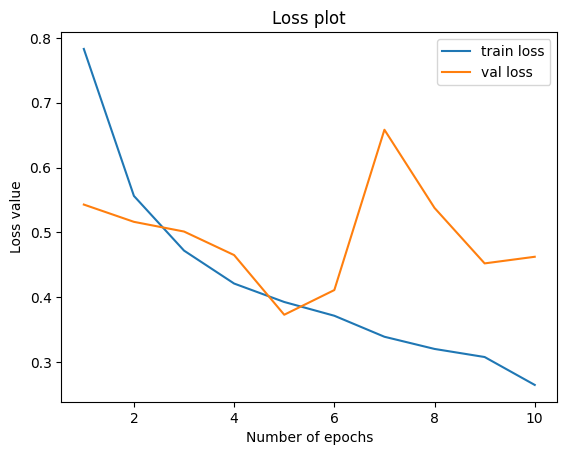

In [ ]:
epochs=[a for a in range(1,num_epochs+1)]
plt.plot(epochs,total_train_loss,label='train loss')
plt.plot(epochs,total_val_loss,label='val loss')
plt.title('Loss plot')
plt.xlabel('Number of epochs')
plt.ylabel('Loss value')

plt.legend()
plt.show()

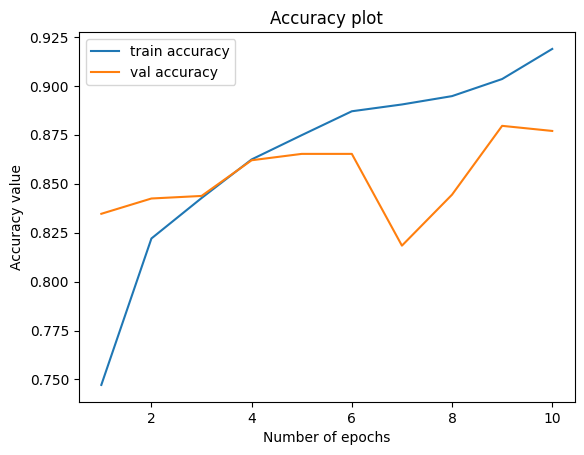

In [ ]:
epochs=[a for a in range(1,num_epochs+1)]
plt.plot(epochs,total_train_accuracy,label='train accuracy')
plt.plot(epochs,total_val_accuracy,label='val accuracy')
plt.title('Accuracy plot')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy value')

plt.legend()
plt.show()

# **Evaluation metrics**

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_loader)

100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Greens', ax=ax)
    plt.xticks(rotation=20)


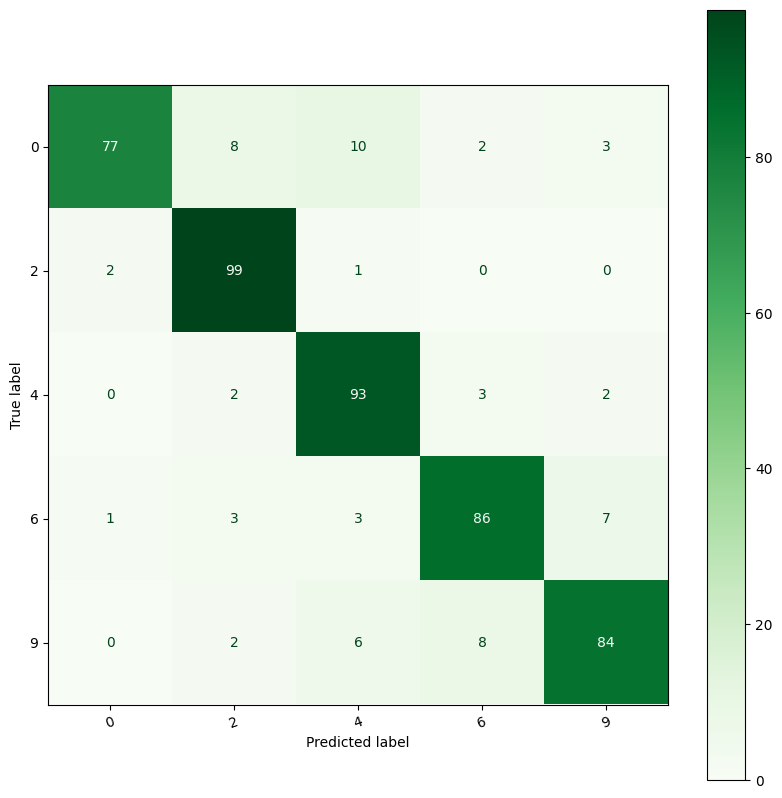

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
from sklearn.metrics import accuracy_score
# accuracy
accuracy_score(labels,pred_labels)

0.8745019920318725

In [ ]:
from sklearn.metrics import f1_score
#f1 score
f1_score(labels,pred_labels,average='weighted')

0.873557660828353

In [ ]:
from sklearn.metrics import f1_score
#f1 score
f1_score(labels,pred_labels,average='macro')

0.8733852248049999

In [ ]:
from sklearn.metrics import f1_score
#f1 score
f1_score(labels,pred_labels,average='micro')

0.8745019920318725

In [ ]:
#precision
from sklearn.metrics import precision_score
precision_score(labels, pred_labels,average='weighted')

0.8794791218981278

In [ ]:
#recall
from sklearn.metrics import recall_score
recall_score(labels, pred_labels,average='weighted')

0.8745019920318725

# **Inference**

In [ ]:
#load the trained model
model_path=os.path.join('/content/drive/MyDrive/smart_data_solutions/ML/models/model_resnet1.pt')
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
classes = ['0', '2', '4', '6', '9']

In [ ]:
def prediction(img_path,transformer):
  image=Image.open(img_path)

  # Convert grayscale image to RGB
  image = image.convert("RGB")
    
  image_tensor=transformer(image).float()
  # print(image_tensor)
  
  
  image_tensor=image_tensor.unsqueeze_(0)
  # print(image_tensor)

  image_tensor=image_tensor.to(device)
  
  # if torch.cuda.is_available():
  #     image_tensor.cuda()
      
  input=Variable(image_tensor)
  
  
  y_pred,_=model(input)

  # y_prob = F.softmax(y_pred, dim=-1)
  
  index=y_pred.cpu().data.numpy().argmax()
  
  pred=classes[index]
  
  return pred

In [ ]:
imp='/content/drive/MyDrive/smart_data_solutions/ML/data/0_category.TIF'

predic=prediction(imp,test_transforms)

print(predic)

0
